Falco Valentina, Flores Lorena

# Proyecto Final: Rendimiento de establecimientos de Salud 2005-2022

Este trabajo analiza cómo funcionaron los hospitales de la Provincia de Buenos Aires entre 2005 y 2022, el detalle del rendimiento de los establecimientos teniendo en cuenta la información de: cantidad de consultas odontológicas, médicas y paramédicas, interconsultas, egresos, camas disponibles, días de estadía, etc. A partir de datos oficiales, se observa el rendimiento de distintos centros de salud en cada municipio y región sanitaria. El objetivo es entender mejor cómo evolucionó el sistema hospitalario en ese período,  identificar patrones, analizar diferencias entre zonas y analizar posibles mejoras a futuro.

Dataset: https://catalogo.datos.gba.gob.ar/th/dataset/rendimientos-establecimientos-salud/archivo/8c3130cb-61ad-4014-b829-503b214ba3c0

Información detallada de las columnas: https://catalogo.datos.gba.gob.ar/dataset/219d6b32-2e34-40cb-913d-b05c47cab75f/resource/52d5fc8d-75a1-4e63-853d-92f8e938e584/download/definiciones-rendimientos-hospitalarios.pdf

El objetivo es analizar la distribución de ingresos, egresos y consultas médicas para conocer el volumen y características de la atención brindada. Calcular indicadores hospitalarios relevantes, como el porcentaje de ocupación de camas, el promedio de días de estadía, el giro de camas y la tasa de mortalidad hospitalaria, que permiten evaluar la eficiencia y calidad del servicio prestado. Detectar posibles desequilibrios entre la cantidad de camas disponibles y la demanda de internación, considerando factores como la estacionalidad anual o la capacidad instalada. Visualizar y modelar tendencias en la evolución de la internación y la ocupación de camas a lo largo del tiempo, lo cual podría contribuir a la planificación y optimización de recursos. Comparar el comportamiento entre distintos servicios médicos y paramédicos, para evaluar la carga asistencial de cada uno y proponer mejoras si fuese necesario.

# **Preparación del entorno**

In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, mean_absolute_error, roc_curve, roc_auc_score, ConfusionMatrixDisplay
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from google.colab import files

# **Preparación de datos**

In [104]:
# --- Pasos de preparación (asegúrate de ejecutarlos) ---
# 1. Cargar el archivo desde la URL
url = 'https://raw.githubusercontent.com/valentinafalco/ProyectoFinal-DS-YPF/main/2da%20PreEntrega/rendimientos-hospitalarios_2005-2022.csv'
df = pd.read_csv(url, sep=';', on_bad_lines='skip')

# 2. Limpiar nombres de columnas (sacar espacios)
df.columns = df.columns.str.strip()

# 3. Rellenar valores faltantes en columnas de texto (esto ya lo tienes)
cols_texto = ['region_sanitaria', 'municipio_nombre']
for col in cols_texto:
    df[col] = df[col].fillna('Desconocido')


# 4. Asegurar que establecimiento_id pueda manejar nulos (convertir a Int64)
# Esto es crucial si hay NaNs o valores que pandas podría interpretar como NaN
try:
    df['establecimiento_id'] = df['establecimiento_id'].astype('Int64')
    print("Columna 'establecimiento_id' convertida a tipo Int64.")
except Exception as e:
    print(f"Advertencia: No se pudo convertir 'establecimiento_id' a Int64. Error: {e}")
    print("Verifica si hay valores no numéricos en la columna.")


# 5. Crear un diccionario con el primer establecimiento_id válido por municipio
# Consideramos válido un ID que NO es nulo Y NO es 0
referencia = df[(df['establecimiento_id'].notna()) & (df['establecimiento_id'] != 0)].drop_duplicates(subset=['municipio_nombre'])[['municipio_nombre', 'establecimiento_id']]
mapa_establecimientos = dict(zip(referencia['municipio_nombre'], referencia['establecimiento_id']))

print("\nEjemplo del mapa_establecimientos (primeros 10):")
print(list(mapa_establecimientos.items())[:10])


# 6. Función para asignar establecimiento_id a los establecimientos con el mismo nombre y agregar nuevos id a los establecimientos que tengan establecimiento_id como '0'
def asignar_establecimiento_corregido(row, mapa, contador):
    # Si el establecimiento_id actual es válido (no nulo y no 0), lo usamos
    if pd.notna(row['establecimiento_id']) and row['establecimiento_id'] != 0:
        return row['establecimiento_id']
    # Si el establecimiento_id actual es nulo o 0, intentamos usar el del mapa
    if row['municipio_nombre'] in mapa:
        return mapa[row['municipio_nombre']]
    else:
        # Si no está en el mapa (nuevo municipio o sin IDs válidos previos), generamos uno nuevo
        nuevo_id = 900000 + contador[0] # Usar un prefijo diferente si 999999 ya está en uso
        contador[0] += 1
        return nuevo_id

# Inicializar contador para IDs nuevos
contador = [1]

# Aplicar la función a cada fila
df['establecimiento_id'] = df.apply(lambda row: asignar_establecimiento_corregido(row, mapa_establecimientos, contador), axis=1)

# 7. Rellenar otros valores numéricos nulos con 0
# Esto se hace después de manejar establecimiento_id
numeric_cols_except_id = df.select_dtypes(include=np.number).columns.tolist()
if 'establecimiento_id' in numeric_cols_except_id:
    numeric_cols_except_id.remove('establecimiento_id') # Asegurarse de no rellenar establecimiento_id

for col in numeric_cols_except_id:
     df[col] = df[col].fillna(0) # Rellenar NaNs en otras columnas numéricas con 0

# 8. Convertir establecimiento_id a tipo int si no quedan nulos
if df['establecimiento_id'].isnull().sum() == 0:
    try:
        df['establecimiento_id'] = df['establecimiento_id'].astype(int)
        print("\nLa columna 'establecimiento_id' se ha convertido a tipo entero (int) después de rellenar.")
    except Exception as e:
         print(f"\nAdvertencia: No se pudo convertir 'establecimiento_id' a int después de rellenar. Error: {e}")
         print("Puede haber valores no enteros o nulos restantes.")
else:
    print("\nAún hay valores nulos en 'establecimiento_id'. No se puede convertir a 'int'. Se mantiene como Int64.")


# 9. Verificación final
print("\nValores faltantes por columna después de la limpieza final:")
print(df.isnull().sum())
print("\nValores únicos en establecimiento_id (primeros 20):")
print(df['establecimiento_id'].unique()[:20])
print("\nConteo de valores 0 en establecimiento_id:")
print((df['establecimiento_id'] == 0).sum())

#
# 10 Convertir la siguiente lista de columnas a integer (en el csv estan como float)
columns_to_convert = [
    'consultas_odontologicas',
    'consultas_medicas',
    'consultas_paramedicas',
    'interconsultas',
    'egresos',
    'dias_camas_disponible',
    'promedio_camas_disponibles',
    'pacientes_dias',
    'porcentaje_ocupacion',
    'dias_estadia',
    'promedio_dias_estadia',
    'defunciones',
    'giro_de_camas',
    'tasa_mortalidad_hospitalaria'
]

# Convertir las columnas float a integer:
for col in columns_to_convert:
    # Verificar si la columna existe en el DataFrame
    if col in df.columns:
        try:
            # Intentar convertir directamente a tipo entero
            df[col] = df[col].astype(int)
            print(f"Columna '{col}' convertida a tipo entero (int).")
        except ValueError:
            # Si falla, puede ser por NaNs o valores no enteros.
            # Intentar convertir a Int64 (soporta NaNs)
            try:
                df[col] = df[col].astype('Int64')
                print(f"Columna '{col}' convertida a tipo entero de pandas (Int64), soporta NaNs.")
            except Exception as e:
                print(f"Error al convertir la columna '{col}' a tipo entero o Int64: {e}")
                print(f"Verifica los valores en '{col}' que impiden la conversión.")
        except Exception as e:
            print(f"Ocurrió un error inesperado al convertir la columna '{col}': {e}")
    else:
        print(f"Advertencia: La columna '{col}' no se encontró en el DataFrame.")

# Verificar los tipos de datos después de la conversión
print("\nTipos de datos después de la conversión:")
print(df[columns_to_convert].dtypes)

 # 11 Mapear y unificar el municipio_id ya que existen filas donde los municipios no tienen ID. Mapeamos por nombre de municipio y completamos la columna municipio_id
# Crear un mapeo confiable de municipio_nombre a municipio_id
# Primero, agrupar por municipio_nombre y contar la frecuencia de cada municipio_id
municipio_id_counts = df.groupby('municipio_nombre')['municipio_id'].value_counts().reset_index(name='count')

# Luego, por cada municipio_nombre, tomar el municipio_id con la mayor frecuencia
# Esto se hace ordenando por cuenta descendente y tomando el primero de cada grupo de municipio_nombre
idx = municipio_id_counts.groupby('municipio_nombre')['count'].idxmax()
mapeo_municipio_id = municipio_id_counts.loc[idx].set_index('municipio_nombre')['municipio_id'].to_dict()

print("Ejemplo del mapeo de municipio_nombre a municipio_id (primeros 10):")
print(list(mapeo_municipio_id.items())[:10])


# Aplicar el mapeo al DataFrame
# Usamos .map() en la columna municipio_nombre para obtener el ID unificado'
# crwamo la columna temporal 'municipio_id_unificado'
df['municipio_id_unificado'] = df['municipio_nombre'].map(mapeo_municipio_id)

# Reemplazar la columna original municipio_id con la unificada
df['municipio_id'] = df['municipio_id_unificado']

# Eliminar la columna temporal
df = df.drop('municipio_id_unificado', axis=1)


# Verificar si hay municipios que aún tienen diferentes IDs (solo debería ocurrir si un municipio_nombre no estaba en el mapeo)
# O si hubo algún problema en el proceso
print("\nVerificando si quedan múltiples municipio_id por municipio_nombre:")
municipio_id_verificacion = df.groupby('municipio_nombre')['municipio_id'].nunique()
municipios_con_multiples_ids = municipio_id_verificacion[municipio_id_verificacion > 1]

if not municipios_con_multiples_ids.empty:
    print("\nLos siguientes municipios_nombre aún tienen múltiples municipio_id:")
    print(municipios_con_multiples_ids)
else:
    print("\nTodos los municipio_nombre ahora tienen un único municipio_id asociado (según el mapeo creado).")

print("\nPrimeras filas con municipio_id unificado:")
print(df[['municipio_nombre', 'municipio_id']].head())

# 12. Exportar el dataframe a un archivo CSV con codificación UTF-8 para actualizar la codificación de los caracteres
df.to_csv('rendimientos-hospitalarios_conID_2005-2022.csv', index=False, encoding='utf-8')

files.download('rendimientos-hospitalarios_conID_2005-2022.csv')

Columna 'establecimiento_id' convertida a tipo Int64.

Ejemplo del mapa_establecimientos (primeros 10):
[('Adolfo Alsina', np.int64(700014)), ('Adolfo Gonzales Chaves', np.int64(1400022)), ('Alberti', np.int64(2100014)), ('Almirante Brown', np.int64(2800032)), ('Avellaneda', np.int64(3500105)), ('Ayacucho', np.int64(4200016)), ('Azul', np.int64(4900042)), ('Bahía Blanca', np.int64(5600034)), ('Balcarce', np.int64(6300026)), ('Baradero', np.int64(7000034))]

La columna 'establecimiento_id' se ha convertido a tipo entero (int) después de rellenar.

Valores faltantes por columna después de la limpieza final:
anio                            0
region_sanitaria                0
municipio_id                    0
municipio_nombre                0
establecimiento_id              0
establecimiento_nombre          0
dependencia                     0
consultas_odontologicas         0
consultas_medicas               0
consultas_paramedicas           0
interconsultas                  0
egresos      

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [105]:
df_final = df.copy()
pd.options.display.max_columns = None
df_final

,anio,region_sanitaria,municipio_id,municipio_nombre,establecimiento_id,establecimiento_nombre,dependencia,consultas_odontologicas,consultas_medicas,consultas_paramedicas,interconsultas,egresos,dias_camas_disponible,promedio_camas_disponibles,pacientes_dias,porcentaje_ocupacion,dias_estadia,promedio_dias_estadia,defunciones,giro_de_camas,tasa_mortalidad_hospitalaria
0,2005,I,60007,Adolfo Alsina,700014,Hospital Local General José de San Martín,Municipal,6424,94401,18888,0,1474,10963,30,4798,44,4529,3,42,49,3
1,2005,I,60007,Adolfo Alsina,700014,Hospital Dr. Noe Yarcho,Municipal,4493,18370,4459,0,471,10950,30,2184,20,2027,4,20,16,4
2,2005,I,60007,Adolfo Alsina,700014,Hogar de Ancianos General N. Levalle,Municipal,0,0,0,0,2,12740,35,11371,89,848,424,1,0,50
3,2005,I,60007,Adolfo Alsina,700014,Hospital Demetrio Carmelo Loyarte,Municipal,0,2024,846,0,120,6570,18,278,4,279,2,1,7,1
4,2005,I,60007,Adolfo Alsina,700014,Unidad Sanitaria San Miguel Arcangel,Municipal,3086,2196,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38988,2022,V,60882,Zárate,88200491,Hogar del Niño Santa Teresa,Municipal,0,0,0,0,0,0,0,0,0,0,0,0,0,0
38989,2022,V,60882,Zárate,88200539,Sala de Pros. Aux. Mitre,Municipal,0,0,0,0,0,0,0,0,0,0,0,0,0,0
38990,2022,V,60882,Zárate,88200687,Sala de Pros. Aux. Bo. Zárate,Municipal,0,0,0,0,0,0,0,0,0,0,0,0,0,0
38991,2022,V,60882,Zárate,88200695,Sala de Pros. Aux. Pro Tierra,Municipal,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Agregar nueva columna 'tipo_establecimiento': Para identificar los establecimientos que son Hospitales de los que no lo son y poder obtener los outliers en los features: dias_camas_disponible, promedio_camas_disponibles, pacientes_dias, porcentaje_ocupacion, entre otros. Los establecimientos de atención primaria no tienen que tener esos features con datos.

In [106]:
df_final['tipo_establecimiento'] = df_final['establecimiento_nombre'].apply(lambda x: 1 if 'Hosp' in str(x) else 0)

In [107]:
print(df_final[['establecimiento_nombre', 'establecimiento_id', 'tipo_establecimiento']])

                          establecimiento_nombre  establecimiento_id  \
0      Hospital Local General José de San Martín              700014   
1                        Hospital Dr. Noe Yarcho              700014   
2           Hogar de Ancianos General N. Levalle              700014   
3              Hospital Demetrio Carmelo Loyarte              700014   
4           Unidad Sanitaria San Miguel Arcangel              700014   
...                                          ...                 ...   
38988                Hogar del Niño Santa Teresa            88200491   
38989                   Sala de Pros. Aux. Mitre            88200539   
38990              Sala de Pros. Aux. Bo. Zárate            88200687   
38991              Sala de Pros. Aux. Pro Tierra            88200695   
38992                                     UPA 14            88200873   

       tipo_establecimiento  
0                         1  
1                         1  
2                         0  
3              

ELIMINAR VALORES ATÍPICOS:  para el tipo_establecimiento igual a 0 (lo que significa que no es un hospital), establecer varias métricas relacionadas a 0, ya que estas métricas suelen ser relevantes solo para hospitales con camas.

In [108]:
# Definir la lista de columnas a establecer en 0
columns_to_zero = [
    'egresos',
    'dias_camas_disponible',
    'promedio_camas_disponibles',
    'pacientes_dias',
    'porcentaje_ocupacion',
    'dias_estadia',
    'promedio_dias_estadia',
    'defunciones',
    'giro_de_camas',
    'tasa_mortalidad_hospitalaria'
]

# Crea una máscara booleana para las filas donde 'tipo_establecimiento' es 0
mask_not_hospital = df_final['tipo_establecimiento'] == 0

# Para las filas donde la máscara es True, establece las columnas especificadas a 0
df_final.loc[mask_not_hospital, columns_to_zero] = 0


# Verificar los datos con el índice de la primera fila donde tipo_establecimiento es 0
first_non_hospital_index = df_final[df_final['tipo_establecimiento'] == 0].index[0]
print("\nFila de ejemplo donde tipo_establecimiento es 0:")
print(df_final.loc[first_non_hospital_index, ['establecimiento_nombre', 'tipo_establecimiento'] + columns_to_zero])


Fila de ejemplo donde tipo_establecimiento es 0:
establecimiento_nombre          Hogar de Ancianos General N. Levalle
tipo_establecimiento                                               0
egresos                                                            0
dias_camas_disponible                                              0
promedio_camas_disponibles                                         0
pacientes_dias                                                     0
porcentaje_ocupacion                                               0
dias_estadia                                                       0
promedio_dias_estadia                                              0
defunciones                                                        0
giro_de_camas                                                      0
tasa_mortalidad_hospitalaria                                       0
Name: 2, dtype: object


Análisis y Conversión de Tipos de Datos - VERIFICAR QUE LOS DATOS NUMÉRICOS SEAN ENTEROS SIN DECIMALES

In [109]:
# Revisar los tipos de datos actuales
print(df_final.info())

# Convertir columnas numéricas si no lo están ya
# Identificar las columnas numéricas y aplicar pd.to_numeric sin decimales

numeric_cols = ['anio', 'consultas_odontologicas', 'consultas_medicas',
                'consultas_paramedicas', 'interconsultas', 'egresos',
                'dias_camas_disponible', 'promedio_camas_disponibles',
                'pacientes_dias', 'porcentaje_ocupacion', 'dias_estadia',
                'promedio_dias_estadia', 'defunciones', 'giro_de_camas',
                'tasa_mortalidad_hospitalaria']

for col in numeric_cols:
    # Usar errors='coerce' convertirá cualquier valor que no pueda ser numérico a NaN
    # Luego puedes decidir cómo manejar esos NaNs (ej. rellenar con 0 o la media)
    df_final[col] = pd.to_numeric(df_final[col], errors='coerce', downcast='integer')


print(df_final['establecimiento_id'])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38993 entries, 0 to 38992
Data columns (total 22 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   anio                          38993 non-null  int64 
 1   region_sanitaria              38993 non-null  object
 2   municipio_id                  38993 non-null  int64 
 3   municipio_nombre              38993 non-null  object
 4   establecimiento_id            38993 non-null  int64 
 5   establecimiento_nombre        38993 non-null  object
 6   dependencia                   38993 non-null  object
 7   consultas_odontologicas       38993 non-null  int64 
 8   consultas_medicas             38993 non-null  int64 
 9   consultas_paramedicas         38993 non-null  int64 
 10  interconsultas                38993 non-null  int64 
 11  egresos                       38993 non-null  int64 
 12  dias_camas_disponible         38993 non-null  int64 
 13  promedio_camas_d

CONSISTENCIA TEMPORAL
Para un análisis a lo largo del tiempo, verifica si hay años faltantes para ciertos establecimientos o si las métricas muestran saltos bruscos que no corresponden a eventos conocidos. Se toman muestras de datos y se obtiene que los años faltantes se refieren a que el establecimiento no existìa en esos años por lo tanto son datos válidos.

In [110]:
# Obtener la lista de todos los nombres de establecimientos únicos
all_establecimientos = df_final['establecimiento_nombre'].unique()

print("Verificando años presentes para cada establecimiento:")

# Iterar sobre cada nombre de establecimiento
for establecimiento in all_establecimientos:
    # Filtrar el DataFrame para el establecimiento actual
    df_establecimiento = df_final[df_final['establecimiento_nombre'] == establecimiento]

    # Obtener los años únicos presentes para este establecimiento
    years_present = df_establecimiento['anio'].unique()

    # Ordenar los años para una mejor visualización
    sorted_years = sorted(years_present)

    # Imprimir la información
    print(f"- Establecimiento '{establecimiento}': Años presentes = {sorted_years}")

# Opcional: Puedes guardar esta información en un diccionario para un acceso más fácil después
years_by_establecimiento = {}
# for establecimiento in all_establecimientos:
#     years_by_establecimiento[establecimiento] = sorted(df_final[df_final['establecimiento_nombre'] == establecimiento]['anio'].unique())

# Puedes ver un ejemplo del diccionario
# print("\nEjemplo del diccionario de años por establecimiento:")
# for key, value in list(years_by_establecimiento.items())[:5]: # Mostrar solo los primeros 5 para no saturar
#     print(f"- '{key}': {value}")

Se truncaron las últimas líneas 5000 del resultado de transmisión.
- Establecimiento 'Hospital Subzonal Gral de Ag. Julio de Vedia': Años presentes = [np.int16(2005), np.int16(2006)]
- Establecimiento 'Hospital Municipal E. Dudignac': Años presentes = [np.int16(2005), np.int16(2006), np.int16(2007), np.int16(2008), np.int16(2009), np.int16(2010), np.int16(2011), np.int16(2012), np.int16(2013), np.int16(2014), np.int16(2015), np.int16(2016), np.int16(2017)]
- Establecimiento 'Hospital Municipal Dr. Manuel Arce': Años presentes = [np.int16(2005), np.int16(2006)]
- Establecimiento 'Hogar Ancianos Sto. Domingo de Guzmán': Años presentes = [np.int16(2005), np.int16(2006)]
- Establecimiento 'Unidad Sanitaria Dr. Jorge Aguilar': Años presentes = [np.int16(2005), np.int16(2006), np.int16(2007), np.int16(2008), np.int16(2009), np.int16(2010), np.int16(2011), np.int16(2012), np.int16(2013), np.int16(2014), np.int16(2015), np.int16(2016), np.int16(2017)]
- Establecimiento 'Unidad Sanitaria Denneh

EVOLUCIÓN DE CONSULTAS MÉDICAS POR ESTABLECIMIENTO Y AÑO - SOLO HOSPITALES
Analizamos los primeros 5 establecimientos. Del análisis surge que:
* Los datos demuestran una tendencia incremental de consultas m`´edicas a partir del 2011 lo que supone que antes de es año no se cargarían la totalidad de los datos.
* Encontramos casos como el Hospital Eva Perón que están duplicados para un mismo municipio. En este caso se observa que el caso 1 tiene consultas desde el 2005 y decrece a 0 en el 2017 y el caso 2 tiene consultas igual a cero desde el 2005 hasta el 2017 y en el 2017 vuelve a tener datos.
"**Se debería tomar la decisión de unificar los datos o eliminar estos casos.**", en este caso se volvió al punto inicial y se agregó el mapeo de municipio_id. Al encontrarnos con establecimiento que tenían distintos nombres y mismo id para un municipio, cambiamos el group by por establecimiento_id


PRIMER GRAFICO MAL AGRUPADO:

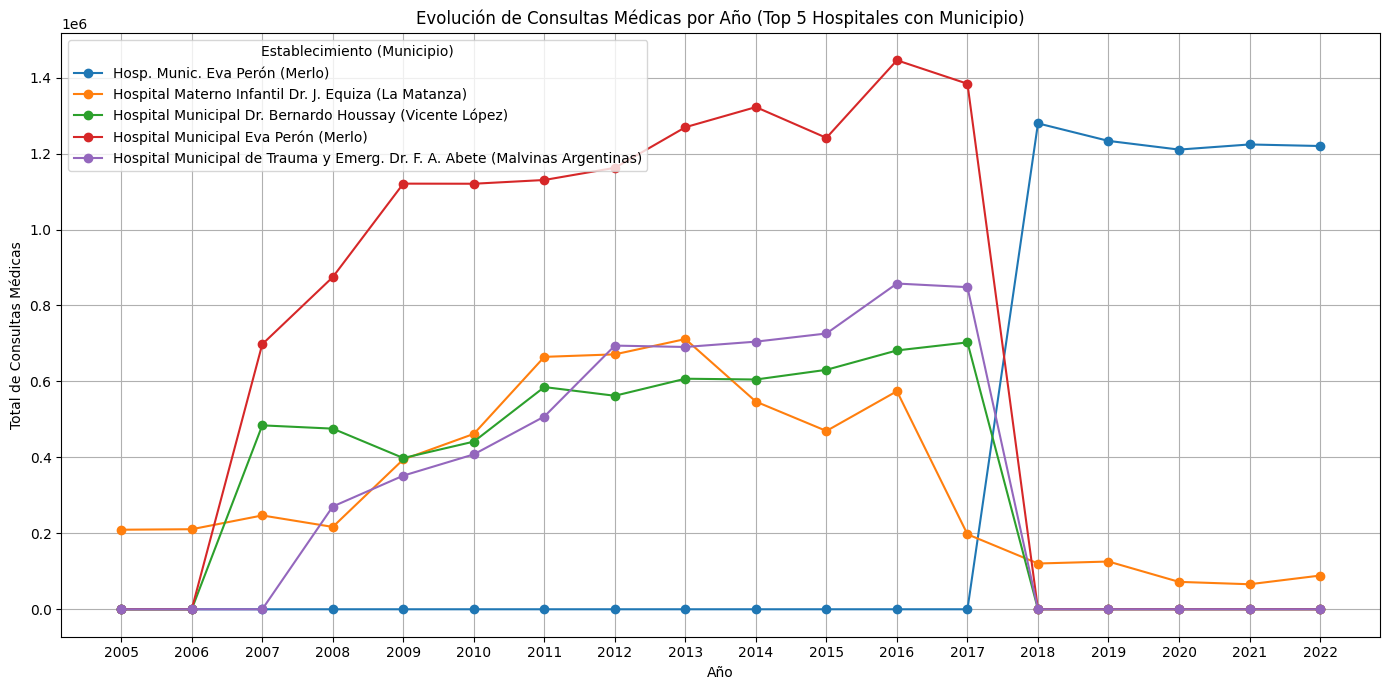

In [111]:
# Filtrar solo hospitales
df_hospitales = df_final[df_final['tipo_establecimiento'] == 1].copy()

# **NUEVO PASO: Concatenar municipio_nombre al establecimiento_nombre**
# Asegurarse de que ambas columnas sean de tipo string para la concatenación
df_hospitales['establecimiento_nombre'] = df_hospitales['establecimiento_nombre'].astype(str) + ' (' + df_hospitales['municipio_nombre'].astype(str) + ')'


# Agrupar por establecimiento_nombre (ahora incluye el municipio) y anio y sumar las consultas medicas
df_grouped = df_hospitales.groupby(['establecimiento_nombre', 'anio'])['consultas_medicas'].sum().reset_index()

# Tomar los 5 hospitales con mayor número total de consultas medicas a lo largo de los años
top_5_establecimientos = df_grouped.groupby('establecimiento_nombre')['consultas_medicas'].sum().nlargest(5).index.tolist()

# Filtrar el dataframe agrupado para incluir solo los top 5 hospitales
df_top_5 = df_grouped[df_grouped['establecimiento_nombre'].isin(top_5_establecimientos)]

# Pivotear para facilitar la graficación (años como columnas)
df_pivot = df_top_5.pivot(index='anio', columns='establecimiento_nombre', values='consultas_medicas').fillna(0)

# Graficar
plt.figure(figsize=(14, 7))
for col in df_pivot.columns:
    plt.plot(df_pivot.index, df_pivot[col], marker='o', linestyle='-', label=col)

# Añadir título y etiquetas
plt.title('Evolución de Consultas Médicas por Año (Top 5 Hospitales con Municipio)')
plt.xlabel('Año')
plt.ylabel('Total de Consultas Médicas')
plt.legend(title='Establecimiento (Municipio)') # Actualizar el título de la leyenda
plt.grid(True)
plt.xticks(df_pivot.index) # Asegurar que se muestren todos los años presentes
plt.tight_layout()
plt.show()

SEGUNDO GRAFICO BIEN AGRUPADO (salvamos la diferencia de nombres y mismo id por lo tanto muestra los datos reales)

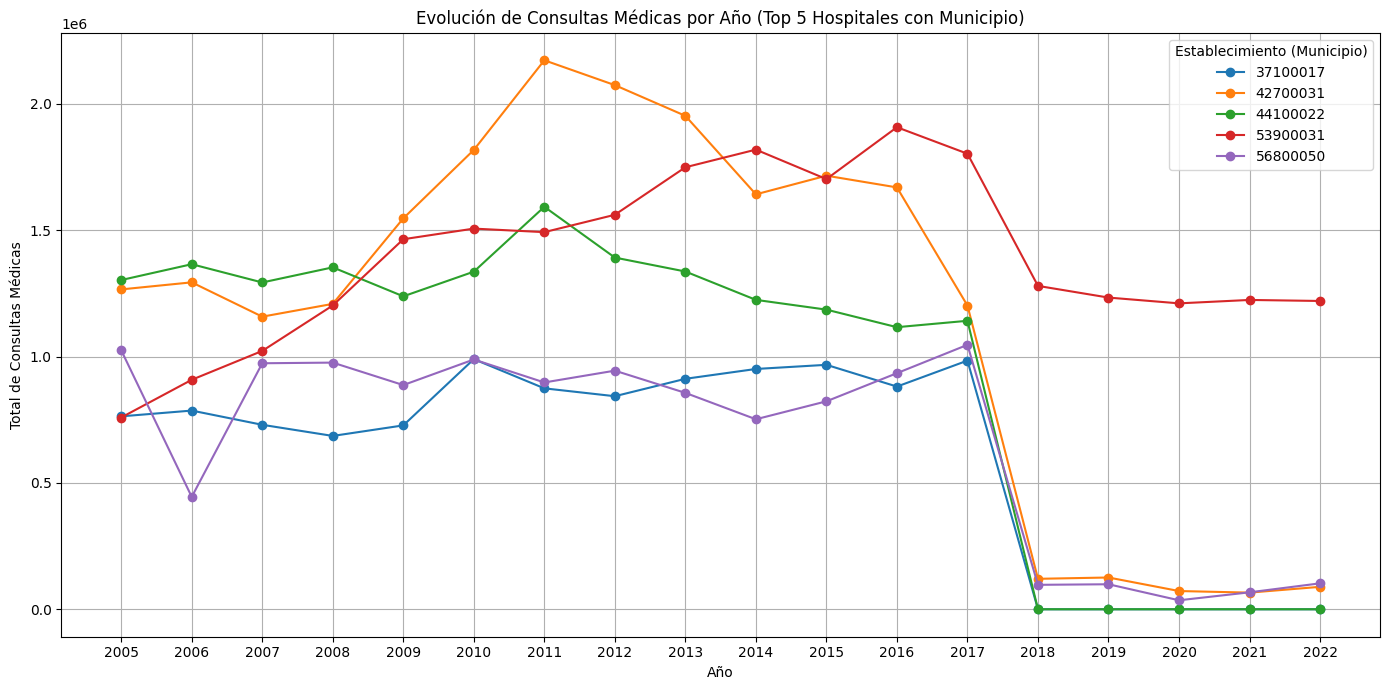

In [112]:
# Filtrar solo hospitales
df_hospitales = df_final[df_final['tipo_establecimiento'] == 1].copy()

# **NUEVO PASO: Concatenar municipio_nombre al establecimiento_nombre**
# Asegurarse de que ambas columnas sean de tipo string para la concatenación
df_hospitales['establecimiento_nombre'] = df_hospitales['establecimiento_nombre'].astype(str) + ' (' + df_hospitales['municipio_nombre'].astype(str) + ')'


# Agrupar por establecimiento_nombre (ahora incluye el municipio) y anio y sumar las consultas medicas
df_grouped = df_hospitales.groupby(['establecimiento_id', 'anio'])['consultas_medicas'].sum().reset_index()

# Tomar los 5 hospitales con mayor número total de consultas medicas a lo largo de los años
top_5_establecimientos = df_grouped.groupby('establecimiento_id')['consultas_medicas'].sum().nlargest(5).index.tolist()

# Filtrar el dataframe agrupado para incluir solo los top 5 hospitales
df_top_5 = df_grouped[df_grouped['establecimiento_id'].isin(top_5_establecimientos)]

# Pivotear para facilitar la graficación (años como columnas)
df_pivot = df_top_5.pivot(index='anio', columns='establecimiento_id', values='consultas_medicas').fillna(0)

# Graficar
plt.figure(figsize=(14, 7))
for col in df_pivot.columns:
    plt.plot(df_pivot.index, df_pivot[col], marker='o', linestyle='-', label=col)

# Añadir título y etiquetas
plt.title('Evolución de Consultas Médicas por Año (Top 5 Hospitales con Municipio)')
plt.xlabel('Año')
plt.ylabel('Total de Consultas Médicas')
plt.legend(title='Establecimiento (Municipio)') # Actualizar el título de la leyenda
plt.grid(True)
plt.xticks(df_pivot.index) # Asegurar que se muestren todos los años presentes
plt.tight_layout()
plt.show()

En base a este caso decidimos actualizar los nombres diferentes para un mismo id en el dataframe:

In [113]:
# 1. Crear un mapeo de establecimiento_id a un nombre representativo
# Agrupar por establecimiento_id y contar la frecuencia de cada establecimiento_nombre

nombre_counts = df_final.groupby('establecimiento_id')['establecimiento_nombre'].value_counts().reset_index(name='count')

# Para cada establecimiento_id, tomar el establecimiento_nombre con la mayor frecuencia
# Esto se hace ordenando por cuenta descendente y tomando el primero de cada grupo de establecimiento_id
idx = nombre_counts.groupby('establecimiento_id')['count'].idxmax()
mapeo_nombre_establecimiento = nombre_counts.loc[idx].set_index('establecimiento_id')['establecimiento_nombre'].to_dict()

print("Ejemplo del mapeo de establecimiento_id a nombre unificado (primeros 10):")
print(list(mapeo_nombre_establecimiento.items())[:10])

# 2. Aplicar el mapeo al DataFrame original
# Usamos .map() en la columna establecimiento_id para obtener el nombre unificado
# Esto creará una nueva columna temporal o reemplazará la existente
df_final['establecimiento_nombre_unificado'] = df_final['establecimiento_id'].map(mapeo_nombre_establecimiento)

# Reemplazar la columna original establecimiento_nombre con la unificada
# Si quieres mantener la columna original con los nombres tal cual vienen, puedes omitir esta línea
df_final['establecimiento_nombre'] = df_final['establecimiento_nombre_unificado']

# Eliminar la columna temporal
df_final = df_final.drop('establecimiento_nombre_unificado', axis=1)

# 3. Verificación
print("\nVerificando si quedan múltiples establecimiento_nombre por establecimiento_id:")
nombre_verificacion = df_final.groupby('establecimiento_id')['establecimiento_nombre'].nunique()
establecimientos_con_multiples_nombres = nombre_verificacion[nombre_verificacion > 1]

if not establecimientos_con_multiples_nombres.empty:
    print("\nLos siguientes establecimiento_id aún tienen múltiples establecimiento_nombre:")
    print(establecimientos_con_multiples_nombres)

else:
    print("\nTodos los establecimiento_id ahora tienen un único establecimiento_nombre asociado (según el mapeo creado).")

print("\nPrimeras filas con establecimiento_nombre unificado:")
print(df_final[['establecimiento_id', 'establecimiento_nombre']].head())



Ejemplo del mapeo de establecimiento_id a nombre unificado (primeros 10):
[(700014, 'Hogar de Ancianos General N. Levalle'), (700022, 'Unid. Sanit. San Miguel Arcangel'), (700057, 'Unid. Sanit. Colonia Lapin'), (700065, 'Unid. Sanit. Dr. J.C. Senepart'), (700073, 'Unid. Sanit. Murature'), (700090, 'Hogar de Ancianos Gral. N. Levalle'), (700111, 'Unid. Sanit. Bo. Arturo Illia'), (700120, 'Unid. Sanit. Villa Goldberg'), (700135, 'Hosp. Munic. Dr. Demetrio Carmelo Loyarte'), (700146, 'Hosp. Munic. Dr. Noe Yarcho')]

Verificando si quedan múltiples establecimiento_nombre por establecimiento_id:

Todos los establecimiento_id ahora tienen un único establecimiento_nombre asociado (según el mapeo creado).

Primeras filas con establecimiento_nombre unificado:
   establecimiento_id                establecimiento_nombre
0              700014  Hogar de Ancianos General N. Levalle
1              700014  Hogar de Ancianos General N. Levalle
2              700014  Hogar de Ancianos General N. Levalle

Ejecutamos el PRIMER GRAFICO ahora bien AGRUPADO por id y vemos que coincide con el segundo gráfico donde tuvimos que agrupar por nombre del establecimiento, Se normalizaron los datos.

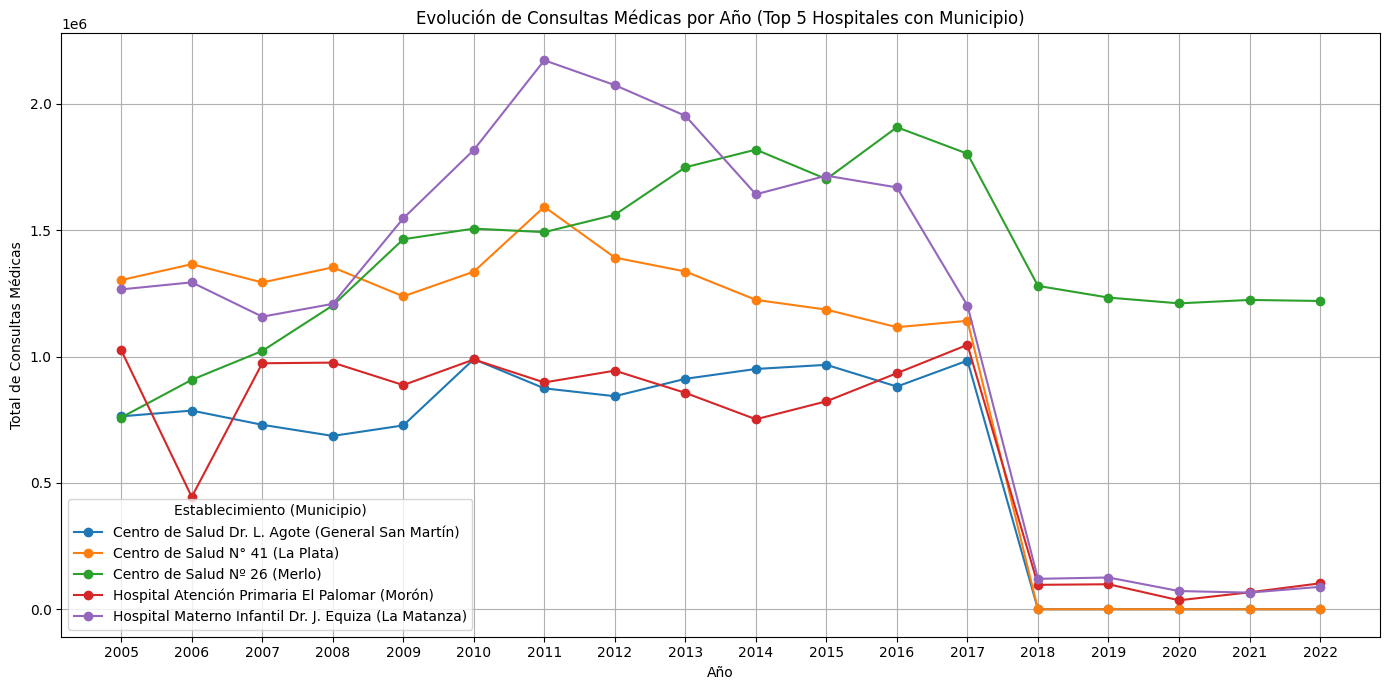

In [114]:
# Filtrar solo hospitales
df_hospitales = df_final[df_final['tipo_establecimiento'] == 1].copy()

# **NUEVO PASO: Concatenar municipio_nombre al establecimiento_nombre**
# Asegurarse de que ambas columnas sean de tipo string para la concatenación
df_hospitales['establecimiento_nombre'] = df_hospitales['establecimiento_nombre'].astype(str) + ' (' + df_hospitales['municipio_nombre'].astype(str) + ')'


# Agrupar por establecimiento_nombre (ahora incluye el municipio) y anio y sumar las consultas medicas
df_grouped = df_hospitales.groupby(['establecimiento_nombre', 'anio'])['consultas_medicas'].sum().reset_index()

# Tomar los 5 hospitales con mayor número total de consultas medicas a lo largo de los años
top_5_establecimientos = df_grouped.groupby('establecimiento_nombre')['consultas_medicas'].sum().nlargest(5).index.tolist()

# Filtrar el dataframe agrupado para incluir solo los top 5 hospitales
df_top_5 = df_grouped[df_grouped['establecimiento_nombre'].isin(top_5_establecimientos)]

# Pivotear para facilitar la graficación (años como columnas)
df_pivot = df_top_5.pivot(index='anio', columns='establecimiento_nombre', values='consultas_medicas').fillna(0)

# Graficar
plt.figure(figsize=(14, 7))
for col in df_pivot.columns:
    plt.plot(df_pivot.index, df_pivot[col], marker='o', linestyle='-', label=col)

# Añadir título y etiquetas
plt.title('Evolución de Consultas Médicas por Año (Top 5 Hospitales con Municipio)')
plt.xlabel('Año')
plt.ylabel('Total de Consultas Médicas')
plt.legend(title='Establecimiento (Municipio)') # Actualizar el título de la leyenda
plt.grid(True)
plt.xticks(df_pivot.index) # Asegurar que se muestren todos los años presentes
plt.tight_layout()
plt.show()

EVOLUCIÓN DE CONSULTAS MÉDICAS POR ESTABLECIMIENTO Y AÑO - NO HOSPITALES.

Analizamos los primeros 5 establecimientos. Del análisis surge que:

* Los hogares de Ancianos no tienen consultas médicas.
* Los establecimientos que brindan servicio de antropozoonosis (enfermedades que se transmiten de humanos a animales) tuvieron pocas consultas médicas y se mantuvo estable no tuvo valores fuera de la curva.
* Los centros antirrábicos humanos (prevenir y tratar la rabia en humanos) tuvieron un patrón de crecimiento a partir del año 2009 y se mantuvo ligeramente constante a lo largo de los años hasta el 2022.
* La unidad de salud ambiental tuvo un crecimiento exponencial desde su fecha de inauguración hasta el 2022.

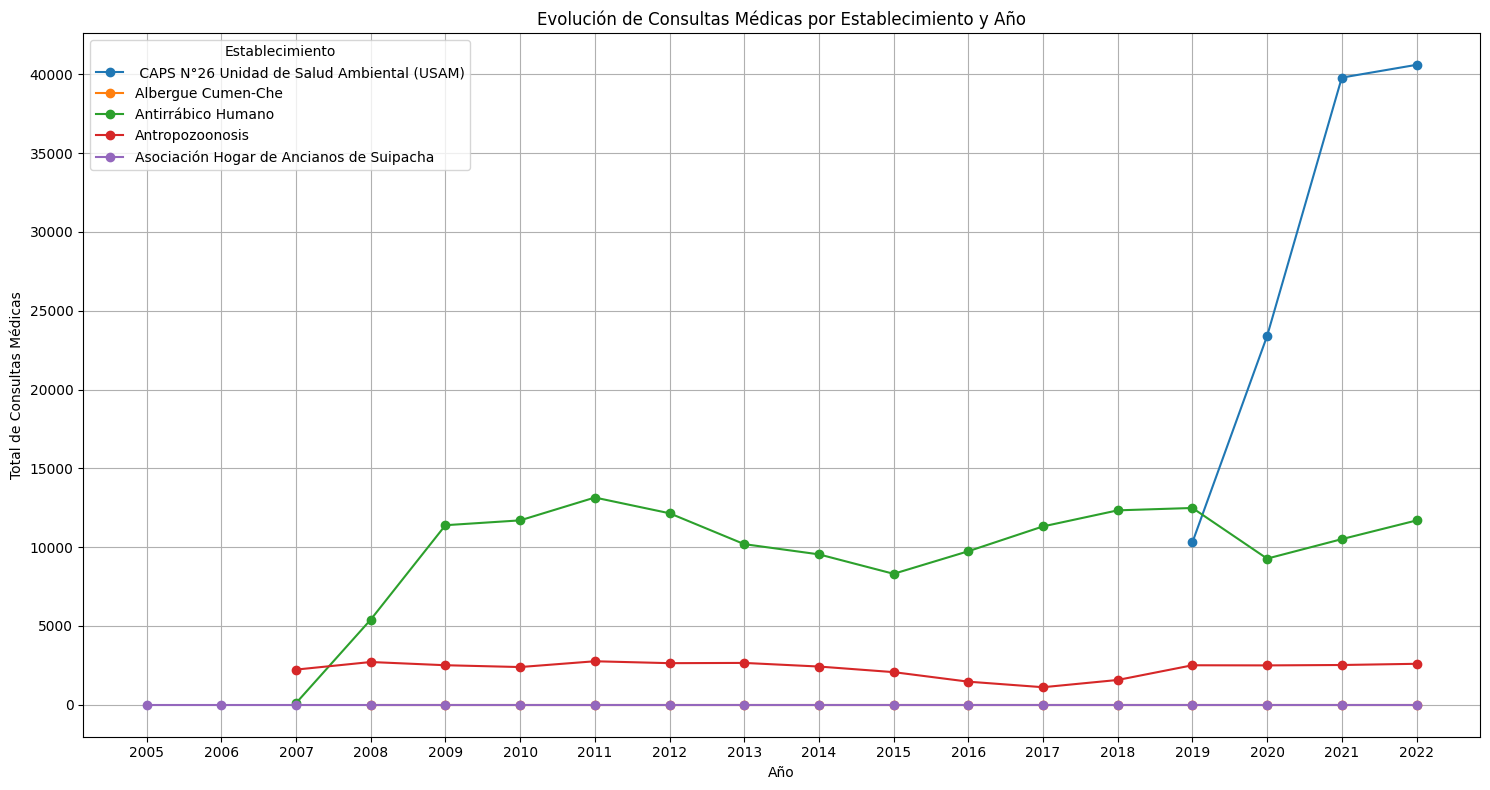

In [115]:
# Agrupar por establecimiento_nombre y anio y sumar las consultas medicas
df_agrupado_consultas = df.groupby(['establecimiento_nombre', 'anio'])['consultas_medicas'].sum().reset_index()

# Seleccionar algunos establecimientos para visualizar (puedes ajustar esta lista)
establecimientos_a_graficar = df_agrupado_consultas['establecimiento_nombre'].unique()[:5] # Tomar los primeros 5

# Crear un gráfico de líneas para mostrar la evolución de las consultas médicas por año para cada establecimiento
plt.figure(figsize=(15, 8)) # Ajustar el tamaño del gráfico

for establecimiento in establecimientos_a_graficar:
    df_establecimiento = df_agrupado_consultas[df_agrupado_consultas['establecimiento_nombre'] == establecimiento]
    plt.plot(df_establecimiento['anio'], df_establecimiento['consultas_medicas'], marker='o', label=establecimiento)

# Añadir título y etiquetas
plt.title('Evolución de Consultas Médicas por Establecimiento y Año')
plt.xlabel('Año')
plt.ylabel('Total de Consultas Médicas')
plt.grid(True)
plt.legend(title='Establecimiento')
plt.xticks(df_agrupado_consultas['anio'].unique()) # Asegura que se muestren todos los años en el eje x
plt.tight_layout()
plt.show()

**DESCARGA DEL ARCHIVO CSV PARA CONTINUAR CON EL ANÁLISIS EXPLORATORIO DE LOS DATOS**

In [116]:
#Exportar el dataframe a un archivo CSV con codificación UTF-8 para actualizar la codificación de los caracteres
df_final.to_csv('rendimientos-hospitalarios_limpio_2005-2022.csv', index=False, encoding='utf-8')


files.download('rendimientos-hospitalarios_limpio_2005-2022.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [117]:
# ESTADISTICAS DESCRIPTIVAS

# AÑO DE INGRESO DE LA CONSULTA MEDICA
df['anio'].describe()

,anio
count,38993.000000
mean,2013.767163
std,5.161545
min,2005.000000
25%,2009.000000
50%,2014.000000
75%,2018.000000
max,2022.000000


Text(0, 0.5, 'Frecuencia')

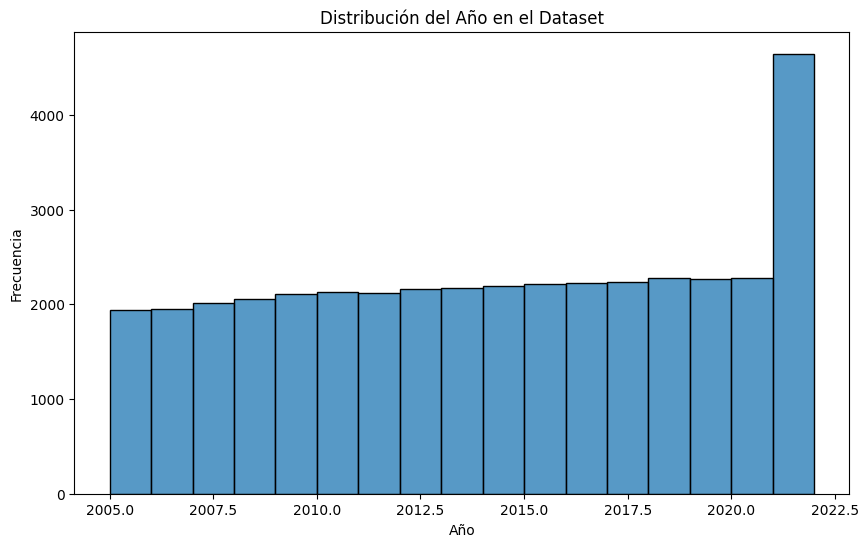

In [118]:
# Crear un histograma de la columna 'anio'
plt.figure(figsize=(10, 6)) # Ajustar el tamaño del gráfico
sns.histplot(data=df, x='anio', bins=sorted(df['anio'].unique()), kde=False) # bins para cada año único, kde=False desactiva la curva de densidad

# Añadir título y etiquetas
plt.title('Distribución del Año en el Dataset')
plt.xlabel('Año')
plt.ylabel('Frecuencia')


GRAFICO DE LOS ESTABLECIMIENTOS CON MAYOR CANTIDAD DE CONSULTAS

Los cuatro gráficos visualizan los establecimientos con mayor volumen de actividad para diferentes tipos de consultas médicas registradas en el conjunto de datos a lo largo de los años 2005-2022. Cada gráfico de barras muestra la suma total del tipo de consulta respectivo para los 10 establecimientos principales en esa categoría específica.

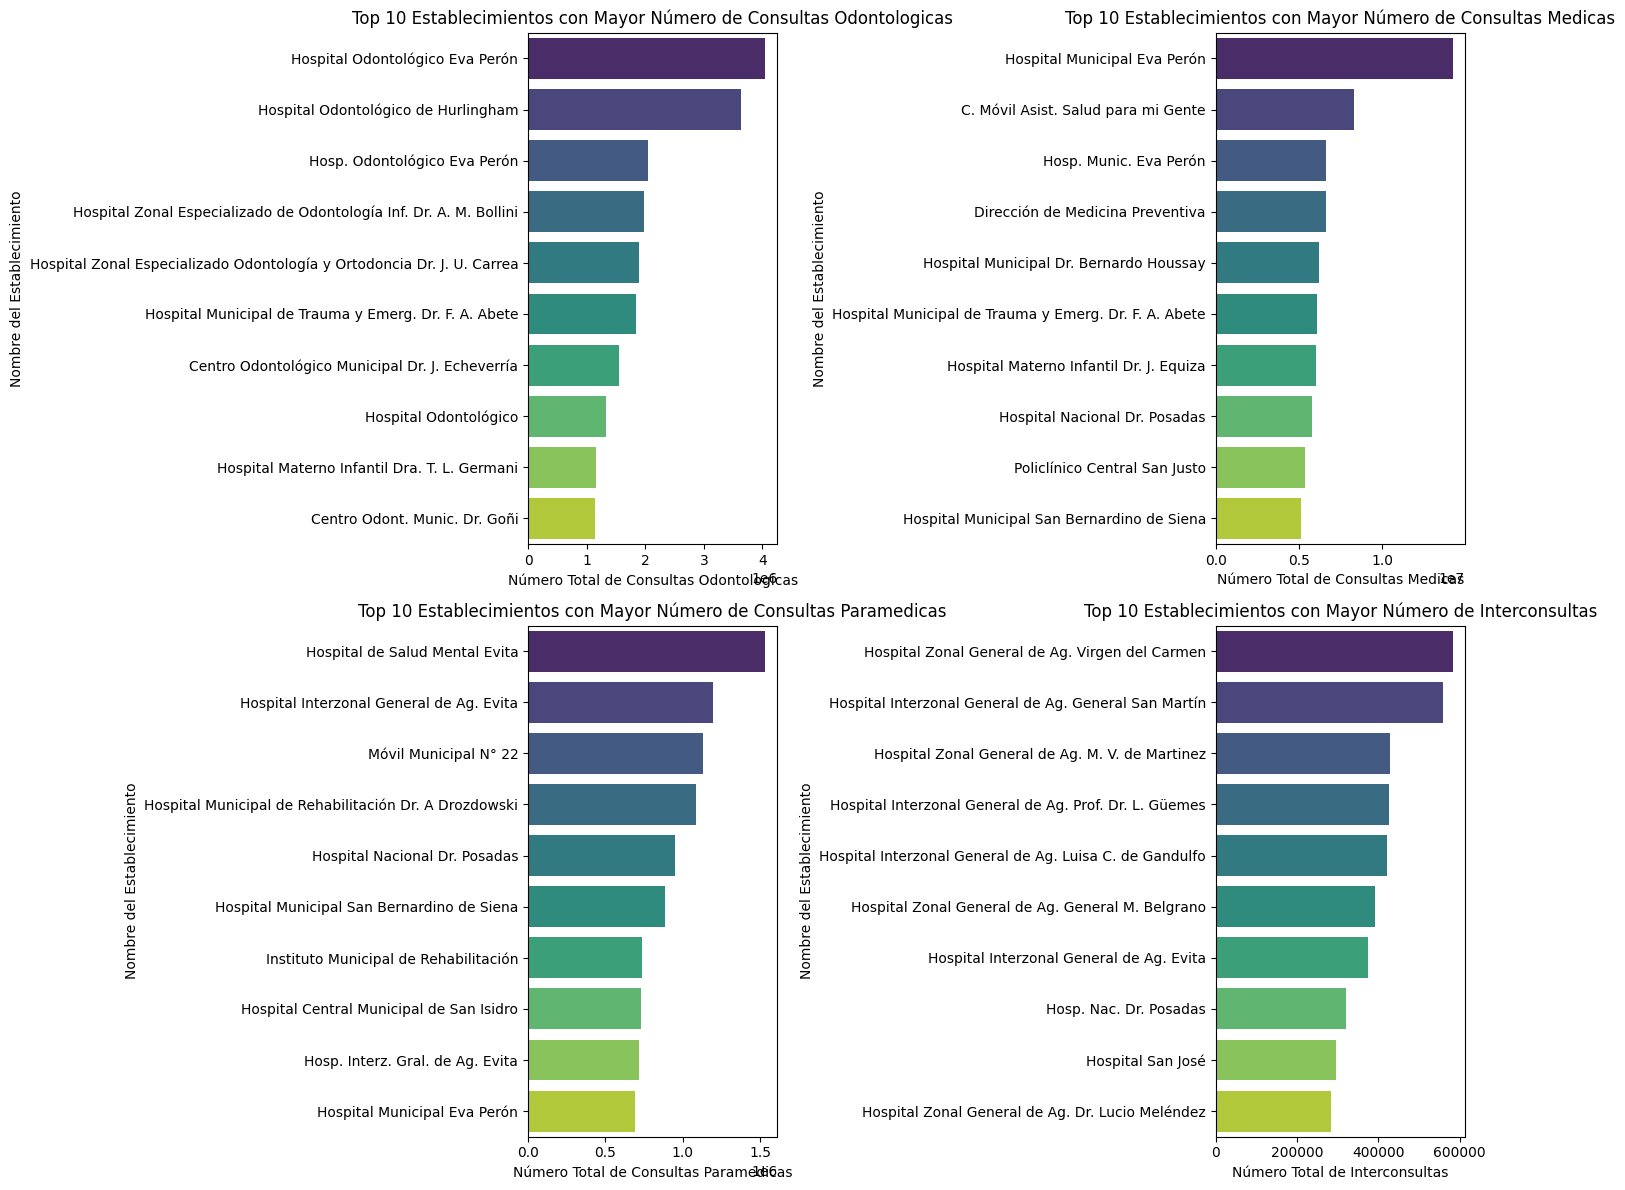

In [119]:
# Lista de columnas de interés para los gráficos
consulta_cols = ['consultas_odontologicas', 'consultas_medicas', 'consultas_paramedicas', 'interconsultas']

# Número de top establecimientos a mostrar en cada gráfico
top_n = 10

# Crear una figura y un conjunto de subplots (2 filas, 2 columnas)
fig, axes = plt.subplots(2, 2, figsize=(15, 12)) # Ajustar el tamaño general de la figura

# Aplanar el array de ejes para poder iterar fácilmente
axes = axes.flatten()

# Iterar sobre cada columna y crear un gráfico
for i, col in enumerate(consulta_cols):
    # 1. Agrupar por establecimiento_nombre y sumar la columna actual
    # Asegurarse de que la columna exista en el DataFrame
    if col in df.columns:
        total_por_establecimiento = df.groupby('establecimiento_nombre')[col].sum().reset_index()

        # 2. Ordenar por el total de la columna actual de forma descendente
        total_por_establecimiento_orden = total_por_establecimiento.sort_values(by=col, ascending=False)

        # 3. Seleccionar los top N establecimientos para visualizar
        top_establecimientos = total_por_establecimiento_orden.head(top_n)

        # 4. Crear un gráfico de barras en el subplot correspondiente
        sns.barplot(x=col, y='establecimiento_nombre', data=top_establecimientos, palette='viridis', ax=axes[i], hue='establecimiento_nombre')

        # Añadir título y etiquetas al subplot
        axes[i].set_title(f'Top {top_n} Establecimientos con Mayor Número de {col.replace("_", " ").title()}') # Título descriptivo
        axes[i].set_xlabel(f'Número Total de {col.replace("_", " ").title()}')
        axes[i].set_ylabel('Nombre del Establecimiento')

        # Mejorar el layout del subplot si es necesario (aunque tight_layout al final ayuda)
        # axes[i].tight_layout() # Esto se hace mejor una vez al final para toda la figura
    else:
        print(f"Advertencia: La columna '{col}' no se encontró en el DataFrame.")
        # Opcional: Ocultar el subplot si la columna no existe
        fig.delaxes(axes[i])


# Ajustar el layout general de la figura para evitar solapamientos
plt.tight_layout()

# Mostrar la figura con todos los subplots
plt.show()


# **Preprocesamiento de datos**



In [120]:
!pip install --upgrade scikit-learn
from sklearn.preprocessing import RobustScaler
from sklearn.compose import ColumnTransformer


ESCALADO

¿Por qué escalamos los datos?

Ponemos un ejemplo claro tomandolos los dos features: consultas_medicas (que puede tener valores desde 0 hasta miles) y porcentaje_ocupacion (que está entre 0 y 100). Si alimentamos estos datos directamente a un algoritmo como K-Nearest Neighbors (KNN) o Support Vector Machines (SVM), que calculan distancias entre puntos, la feature con valores más grandes (consultas_medicas) dominará el cálculo de la distancia, haciendo que la feature con valores más pequeños (porcentaje_ocupacion) sea prácticamente ignorada, incluso si es muy relevante para la predicción.

El escalado nos ayuda a equilibrar la influencia de todas las features, asegurando que ninguna feature domine artificialmente el proceso de aprendizaje debido a su magnitud.

Vamos a utilizar el Escalado
RobustScaler de la librería sklearn.preprocessing.

RobustScaler: Este escalador es particularmente útil cuando tus datos contienen outliers (valores atípicos). A diferencia de StandardScaler (que usa la media y la desviación estándar, que son sensibles a outliers), RobustScaler utiliza la mediana y el rango intercuartílico (IQR) para escalar los datos.

RobustScaler utiliza la mediana y el rango intercuartílico (IQR) para escalar los datos.
La mediana es el valor central de un conjunto de datos ordenado y no se ve afectada por valores extremos.
El IQR es la diferencia entre el tercer cuartil (75º percentil) y el primer cuartil (25º percentil) y representa la dispersión de la mitad central de los datos, ignorando los extremos.
La fórmula de escalado de RobustScaler para un punto de datos x y una feature j es:

x_scaled[j] = (x[j] - mediana[j]) / IQR[j]

In [121]:
# Definimos las features numéricas y categóricas:
numeric_features = [
    'consultas_odontologicas', 'consultas_medicas', 'consultas_paramedicas',
    'interconsultas', 'egresos', 'dias_camas_disponible', 'promedio_camas_disponibles',
    'pacientes_dias', 'porcentaje_ocupacion', 'dias_estadia', 'promedio_dias_estadia',
    'defunciones', 'giro_de_camas', 'tasa_mortalidad_hospitalaria'
]
categorical_features = ['municipio_nombre', 'region_sanitaria']

# Definimos la variable objetivo (target) validamos que exista en df_final
target = 'promedio_dias_estadia'

# Seleccionamos features y target, manejando NaNs antes de dividir
X = df_final[numeric_features + categorical_features].copy()
y = df_final[target].copy()

#DIVIDIMOS LOS DATOS
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("\nDatos divididos en Train y Test.")
print(f"Forma de X_train: {X_train.shape}")

# --- Configuramos el escalado usando ColumnTransformer ---
print("\n--- Realizando Escalado ---")

# Definimos las columnas numéricas a ser escaladas
cols_to_scale = numeric_features # Usamos la lista definida arriba

# utilizamos RobustScaler porque es menos sensible a outliers
scaler = RobustScaler()

# ColumnTransformer lo usamos para aplicar el escalador solo a las columnas numéricas
# el parámetro 'passthrough' en remainder permite mantener las columnas no listadas sin modificar
preprocessor = ColumnTransformer(
    transformers=[
        ('num', scaler, cols_to_scale)
    ],
    remainder='passthrough'
)

# --- Aplicamos el escalado ---

# 1. Ajustamos el preprocesador (scaler) en el conjunto de ENTRENAMIENTO
#    El preprocesador calcula los parámetros de escalado (media/std o mediana/IQR)
#    basándose ÚNICAMENTE en X_train.
print("Ajustando el escalador en X_train...")
preprocessor.fit(X_train)

# 2. Transformamos el conjunto de ENTRENAMIENTO
#    Aplica el escalado aprendido a X_train.
print("Transformando X_train...")
X_train_scaled = preprocessor.transform(X_train)

# 3. Transformamos el conjunto de PRUEBA
#    Aplicamos el mismo escalado aprendido de X_train a X_test.
print("Transformando X_test...")
X_test_scaled = preprocessor.transform(X_test)

print("Escalado completado.")
print(f"Forma de X_train_scaled: {X_train_scaled.shape}")
print(f"Forma de X_test_scaled: {X_test_scaled.shape}")

# X_train_scaled y X_test_scaled son ahora arrays de NumPy.
# Las primeras columnas corresponden a las features numéricas escaladas y
# las columnas restantes son las otras columnas originales.

try:
    feature_names_out = preprocessor.get_feature_names_out()
    print("\nNombres de las features después del escalado:")
    print(feature_names_out)

    # Convertimos el DataFrame para inspeccionarlo
    X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=feature_names_out, index=X_train.index)
    X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=feature_names_out, index=X_test.index)

    print("\nEstadísticas descriptivas de las features numéricas escaladas (X_train_scaled):")
    # Seleccionamos solo las columnas que fueron escaladas (las primeras en feature_names_out)
    scaled_cols_df = X_train_scaled_df.iloc[:, :len(cols_to_scale)]
    print(scaled_cols_df.describe())

    # Con RobustScaler, la mediana debería estar cerca de 0 y el IQR cerca de 1.

except AttributeError:
    print("\nTu versión de scikit-learn no soporta get_feature_names_out. No se puede mostrar fácilmente el resultado como DataFrame.")
    print("X_train_scaled y X_test_scaled son arrays de NumPy.")


# Ahora puedes usar X_train_scaled y X_test_scaled para entrenar tu modelo.
# Si también necesitas codificar variables categóricas, esto se haría ANTES o DURANTE
# la configuración del ColumnTransformer, incluyendo un transformer para las categóricas.


Datos divididos en Train y Test.
Forma de X_train: (31194, 16)

--- Realizando Escalado ---
Ajustando el escalador en X_train...
Transformando X_train...
Transformando X_test...
Escalado completado.
Forma de X_train_scaled: (31194, 16)
Forma de X_test_scaled: (7799, 16)

Nombres de las features después del escalado:
['num__consultas_odontologicas' 'num__consultas_medicas'
 'num__consultas_paramedicas' 'num__interconsultas' 'num__egresos'
 'num__dias_camas_disponible' 'num__promedio_camas_disponibles'
 'num__pacientes_dias' 'num__porcentaje_ocupacion' 'num__dias_estadia'
 'num__promedio_dias_estadia' 'num__defunciones' 'num__giro_de_camas'
 'num__tasa_mortalidad_hospitalaria' 'remainder__municipio_nombre'
 'remainder__region_sanitaria']

Estadísticas descriptivas de las features numéricas escaladas (X_train_scaled):
        num__consultas_odontologicas  num__consultas_medicas  \
count                        31194.0            31194.000000   
unique                        6834.0        

HISTOGRAMAS

Graficamos algunos aspectos de los datos después del preprocesamiento y escalado. Dado que el escalado ya se ha aplicado a las features numéricas y las categóricas se han mantenido, podemos visualizar las distribuciones de las features numéricas escaladas o la relación entre el target (promedio_dias_estadia) y una de las features numéricas.

**Histograma para visualizar los valores escalados de consultas medicas**

El gráfico de distribución de num__consultas_medicas (Escalado) nos muestra cómo se agrupan los datos de consultas_medicas una vez que han sido centrados por su mediana y escalados por su rango intercuartílico. Nos permite confirmar visualmente que el escalado ha sido aplicado (viendo el pico cerca de 0) y observar la forma de la distribución transformada, incluyendo la presencia de outliers que se manifiestan como valores alejados de 0. Es una forma de inspeccionar el resultado del preprocesamiento en una feature específica.

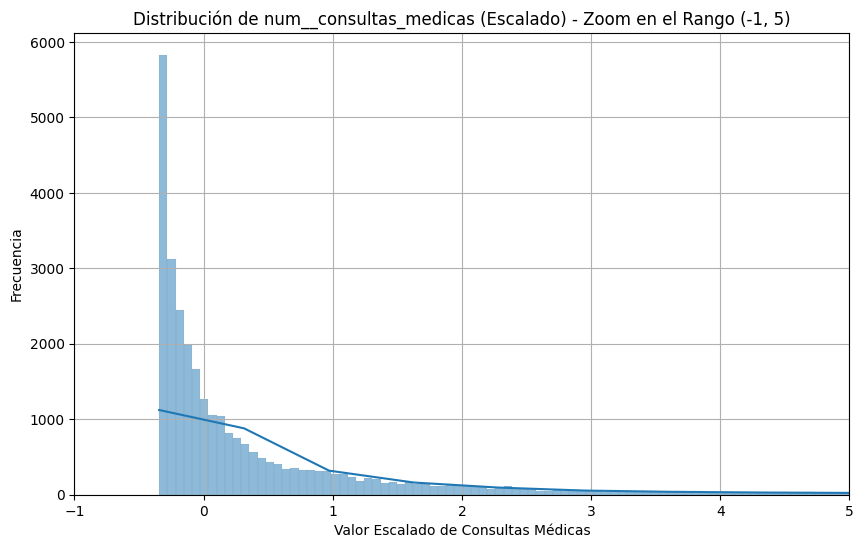

In [122]:
import matplotlib.pyplot as plt
import seaborn as sns

# Selecciona la columna numérica escalada específica para visualizar
scaled_feature_to_plot = 'num__consultas_medicas'

# Asegúrate de que la feature escalada exista en el DataFrame escalado
if scaled_feature_to_plot not in X_train_scaled_df.columns:
     print(f"La columna '{scaled_feature_to_plot}' no se encontró en el DataFrame escalado. Verifica los nombres de feature_names_out.")
else:
    plt.figure(figsize=(10, 6)) # Puedes ajustar el tamaño de la figura si quieres que el gráfico sea más grande en general

    # Crea el histograma para la feature escalada
    sns.histplot(X_train_scaled_df[scaled_feature_to_plot], kde=True)

    # --- Ajustar los límites del Eje X para acercar el zoom ---

    x_min = -1  # Valor mínimo para el eje X
    x_max = 5  # Valor máximo para el eje X
    plt.xlim(x_min, x_max) # Establece los límites del eje X

    # Añade título y etiquetas
    plt.title(f'Distribución de {scaled_feature_to_plot} (Escalado) - Zoom en el Rango ({x_min}, {x_max})') # Actualiza el título para indicar el zoom
    plt.xlabel('Valor Escalado de Consultas Médicas')
    plt.ylabel('Frecuencia')

    # Muestra el gráfico
    plt.grid(True) # Opcional: añade una cuadrícula
    plt.show()

**Histograma para visualizar los valores escalados de camas disponibles**

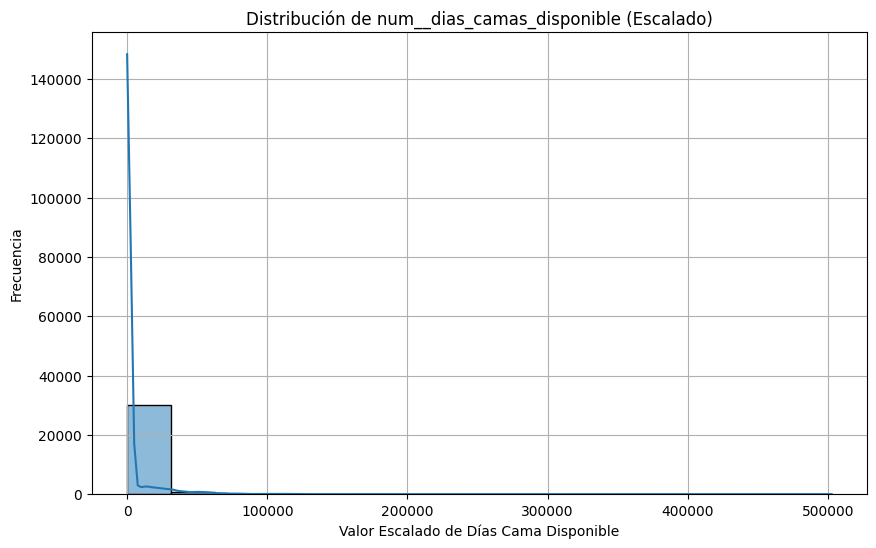

In [123]:
# Selecciona la columna numérica escalada específica para visualizar
scaled_feature_to_plot = 'num__dias_camas_disponible'

# Asegúrate de que la feature escalada exista en el DataFrame escalado
if scaled_feature_to_plot not in X_train_scaled_df.columns:
     print(f"La columna '{scaled_feature_to_plot}' no se encontró en el DataFrame escalado. Verifica los nombres de feature_names_out.")
else:
    plt.figure(figsize=(10, 6)) # Ajusta el tamaño del gráfico si es necesario

    # Crea el histograma para la feature escalada
    sns.histplot(X_train_scaled_df[scaled_feature_to_plot], kde=True) # kde=True añade la curva de densidad

    # Añade título y etiquetas
    plt.title(f'Distribución de {scaled_feature_to_plot} (Escalado)')
    plt.xlabel('Valor Escalado de Días Cama Disponible') # Etiqueta del eje X
    plt.ylabel('Frecuencia') # Etiqueta del eje Y

    # Muestra el gráfico
    plt.grid(True) # Opcional: añade una cuadrícula
    plt.show()

**Histograma para visualizar los valores escalados de promedio de días de estadia**

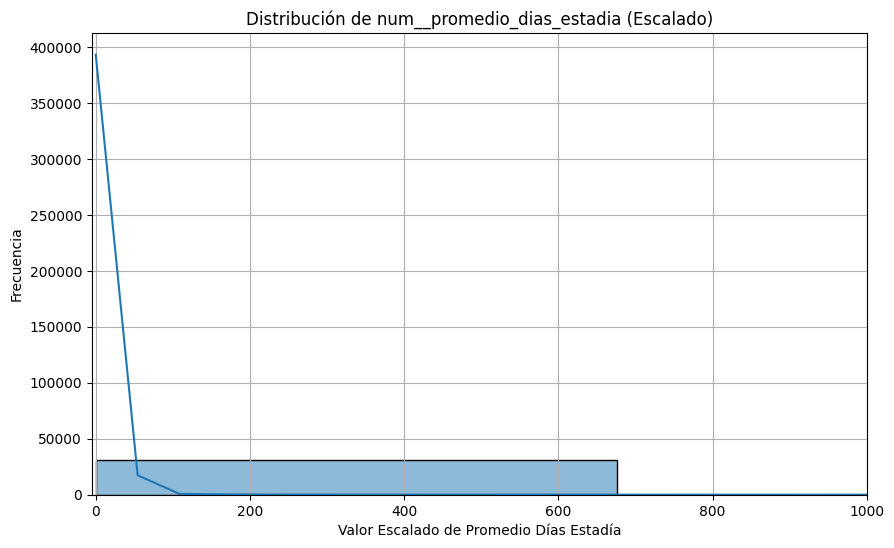

In [124]:
# Selecciona la columna numérica escalada específica para visualizar
scaled_feature_to_plot = 'num__promedio_dias_estadia'

# Asegúrate de que la feature escalada exista en el DataFrame escalado
if scaled_feature_to_plot not in X_train_scaled_df.columns:
     print(f"La columna '{scaled_feature_to_plot}' no se encontró en el DataFrame escalado. Verifica los nombres de feature_names_out.")
else:
    plt.figure(figsize=(10, 6)) # Ajusta el tamaño del gráfico si es necesario

    # Crea el histograma para la feature escalada
    sns.histplot(X_train_scaled_df[scaled_feature_to_plot], kde=True) # kde=True añade la curva de densidad

    # Puedes opcionalmente ajustar los límites de los ejes aquí si deseas hacer zoom
    x_min = -5
    x_max = 1000
    plt.xlim(x_min, x_max)
    # plt.title(f'Distribución de {scaled_feature_to_plot} (Escalado) - Zoom en el Rango ({x_min}, {x_max})') # Actualiza el título si haces zoom

    # Añade título y etiquetas
    plt.title(f'Distribución de {scaled_feature_to_plot} (Escalado)')
    plt.xlabel('Valor Escalado de Promedio Días Estadía') # Etiqueta del eje X
    plt.ylabel('Frecuencia') # Etiqueta del eje Y

    # Muestra el gráfico
    plt.grid(True) # Opcional: añade una cuadrícula
    plt.show()



 MODELO DE REGRESIÓN LINEAL SIMPLE

**Gráfico de Regresión Lineal Simple (Train and Test):**

Este gráfico visualiza el proceso de aprendizaje y la evaluación de nuestro modelo de regresión lineal simple, mostrando la relación entre la variable pacientes_dias y la variable promedio_dias_estadia.

Puntos Verdes (Datos de Entrenamiento): Cada punto verde representa una observación de nuestro conjunto de datos de entrenamiento. Estos son los datos que el modelo utilizó para aprender la relación entre pacientes_dias y promedio_dias_estadia. El modelo ajustó su línea para minimizar el error en estos puntos.
Puntos Azules (Datos de Prueba): Cada punto azul representa una observación de nuestro conjunto de datos de prueba. Estos datos no fueron utilizados durante el entrenamiento y sirven para evaluar qué tan bien el modelo generaliza a datos nuevos y no vistos.
Línea Roja (Predicción del Modelo): Esta línea recta es la representación visual del modelo de regresión lineal entrenado. Fue calculada basándose únicamente en los puntos verdes (datos de entrenamiento). La línea roja muestra la relación lineal que el modelo encontró y representa los valores predichos de promedio_dias_estadia para cualquier valor dado de pacientes_dias en esa línea.
Al visualizar tanto los datos de entrenamiento como los de prueba junto con la línea de regresión, podemos observar:

Cómo el modelo se ajusta a los datos de entrenamiento: La línea roja debería estar razonablemente cerca de los puntos verdes si el entrenamiento fue exitoso.
Qué tan bien el modelo generaliza: Al ver cómo se ajusta la línea roja a los puntos azules (datos de prueba), podemos tener una idea visual de la capacidad del modelo para predecir en datos nuevos. Si la línea se ajusta bien a los puntos azules, el modelo tiene una buena capacidad de generalización. Si hay una gran diferencia entre el ajuste a los puntos verdes y azules, podría haber un indicio de sobreajuste (el modelo aprendió demasiado los detalles específicos de los datos de entrenamiento y no las relaciones generales).
En esencia, este gráfico combinado te da una imagen más completa del rendimiento del modelo, mostrando no solo lo que aprendió, sino también qué tan bien aplica ese aprendizaje a datos que no ha visto antes.

Métricas de evaluación para la Regresión Lineal Simple (pacientes_dias vs promedio_dias_estadia):
Error Absoluto Medio (MAE): 18.01
Error Cuadrático Medio (MSE): 85107.29
Coeficiente de Determinación (R²): 0.01


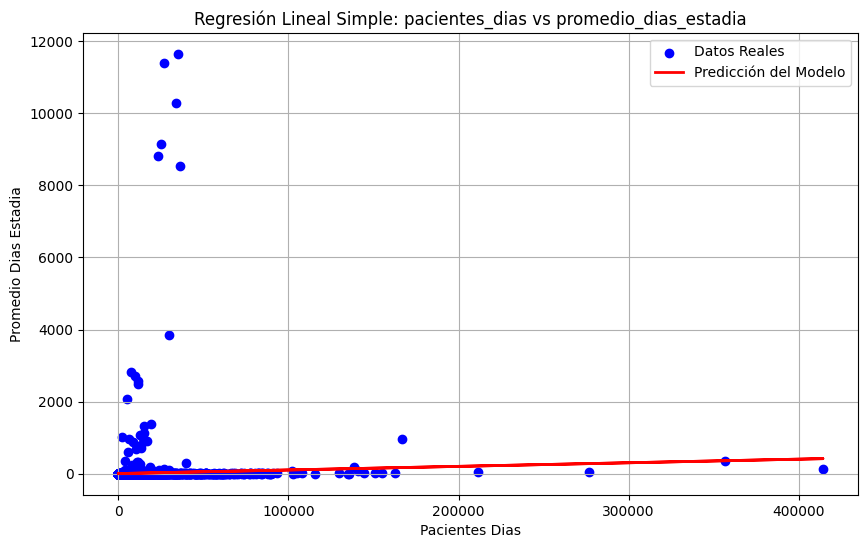

In [130]:
#Predecir el 'promedio_dias_estadia' (y)
# basándonos en 'pacientes_dias' (X),

variable_independiente = 'pacientes_dias' # Variable predictora (X)
variable_dependiente = 'promedio_dias_estadia' # Variable a predecir (y)

# Asegurarse de que las columnas seleccionadas existan y no tengan valores infinitos
if variable_independiente not in df_final.columns or variable_dependiente not in df_final.columns:
    print(f"Error: Una o ambas columnas '{variable_independiente}' o '{variable_dependiente}' no existen en el DataFrame.")
else:
    # Filtrar filas con valores infinitos en las columnas seleccionadas si es necesario
    df_regresion = df_final.replace([np.inf, -np.inf], np.nan).dropna(subset=[variable_independiente, variable_dependiente]).copy()

    # Asegurarse de que haya suficientes datos para la regresión
    if len(df_regresion) == 0:
        print(f"Error: No hay datos válidos para las columnas '{variable_independiente}' y '{variable_dependiente}' después de limpiar infinitos y NaN.")
    else:
        # 2. Preparar los datos para el modelo
        # Es necesario que la variable independiente (X) sea un array 2D
        X = df_regresion[[variable_independiente]]
        y = df_regresion[variable_dependiente]

        # 3. Dividir los datos en conjuntos de entrenamiento y prueba
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # 20% para prueba

        # 4. Crear el modelo de regresión lineal
        modelo = LinearRegression()

        # 5. Entrenar el modelo
        modelo.fit(X_train, y_train)

        # 6. Hacer predicciones en el conjunto de prueba
        y_pred = modelo.predict(X_test)

        # 7. Evaluar el modelo
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        print(f"Métricas de evaluación para la Regresión Lineal Simple ({variable_independiente} vs {variable_dependiente}):")
        print(f"Error Absoluto Medio (MAE): {mae:.2f}")
        print(f"Error Cuadrático Medio (MSE): {mse:.2f}")
        print(f"Coeficiente de Determinación (R²): {r2:.2f}")

        # 8. Visualizar los resultados
        plt.figure(figsize=(10, 6))

        # Graficar los puntos de datos de prueba
        plt.scatter(X_test, y_test, color='blue', label='Datos Reales')

        # Graficar la línea de regresión predicha
        plt.plot(X_test, y_pred, color='red', linewidth=2, label='Predicción del Modelo')

        # Añadir títulos y etiquetas
        plt.title(f'Regresión Lineal Simple: {variable_independiente} vs {variable_dependiente}')
        plt.xlabel(variable_independiente.replace("_", " ").title())
        plt.ylabel(variable_dependiente.replace("_", " ").title())
        plt.legend()
        plt.grid(True)
        plt.show()



Este gráfico muestra la relación entre la variable pacientes_dias y la variable promedio_dias_estadia en nuestro conjunto de datos de prueba.

Puntos Azules (Datos Reales): Cada punto azul representa una observación real de nuestro conjunto de datos de prueba. Su posición en el eje horizontal corresponde al valor real de pacientes_dias para esa observación, y su posición en el eje vertical corresponde al valor real de promedio_dias_estadia. Estos puntos son los datos que el modelo intentó predecir.
Línea Roja (Predicción del Modelo): Esta línea recta representa el modelo de regresión lineal que hemos entrenado. Muestra la relación lineal que el modelo ha aprendido entre pacientes_dias y promedio_dias_estadia. Para cualquier valor dado de pacientes_dias en el eje horizontal, la línea roja indica el valor de promedio_dias_estadia que el modelo predice. Esencialmente, es la "mejor" línea recta que se ajusta a los datos de entrenamiento (y que estamos visualizando sobre los datos de prueba para evaluar qué tan bien se ajusta a datos nuevos).
El objetivo del modelo de regresión lineal es encontrar la línea recta que minimice la distancia entre los puntos de datos reales y la línea predicha. Cuanto más cerca estén los puntos azules de la línea roja, mejor será la capacidad del modelo para predecir promedio_dias_estadia basándose en pacientes_dias.

IDENTIFICAR OUTLIERS utilizando el método del Rango Intercuartílico (IQR)

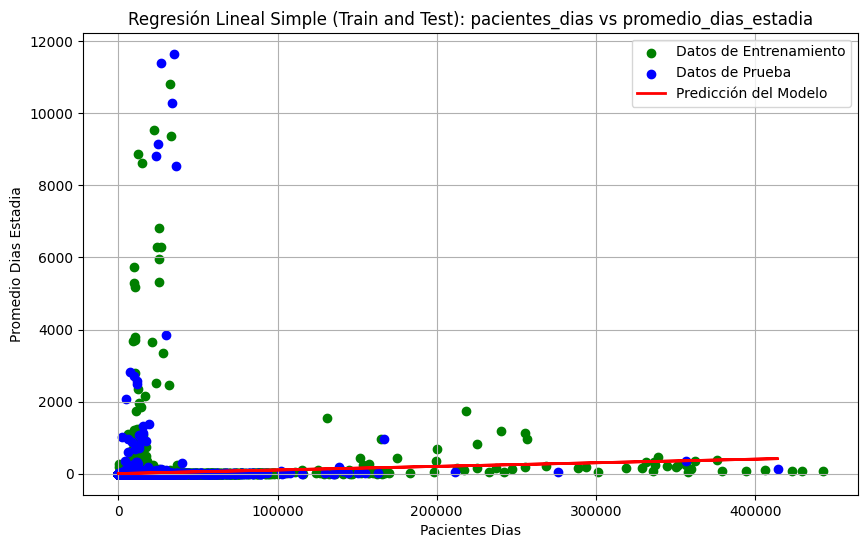

In [126]:
# Visualizar también los datos de entrenamiento
plt.figure(figsize=(10, 6))
plt.scatter(X_train, y_train, color='green', label='Datos de Entrenamiento')
plt.scatter(X_test, y_test, color='blue', label='Datos de Prueba')
plt.plot(X_test, y_pred, color='red', linewidth=2, label='Predicción del Modelo')
plt.title(f'Regresión Lineal Simple (Train and Test): {variable_independiente} vs {variable_dependiente}')
plt.xlabel(variable_independiente.replace("_", " ").title())
plt.ylabel(variable_dependiente.replace("_", " ").title())
plt.legend()
plt.grid(True)
plt.show()

Rango Intercuartílico (IQR)

Un método común para identificar y eliminar outliers es el método del Rango Intercuartílico (IQR). Este método se basa en los cuartiles de la distribución de los datos. [2]

Primer Cuartil (Q1): El valor por debajo del cual cae el 25% de los datos.
Tercer Cuartil (Q3): El valor por debajo del cual cae el 75% de los datos.
Rango Intercuartílico (IQR): Es la diferencia entre el Tercer Cuartil y el Primer Cuartil (IQR = Q3 - Q1).
Los valores que se consideran outliers según este método son aquellos que caen por debajo de Q1 - 1.5 * IQR o por encima de Q3 + 1.5 * IQR. [2]

In [127]:
# Identificar outliers para 'consultas_odontologicas'
col = 'consultas_odontologicas'
if col in df_final.columns:
    print(f"\nIdentificando outliers para la columna: {col}")
    Q1 = df_final[col].quantile(0.25)
    Q3 = df_final[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers_odontologicas = df_final[(df_final[col] < lower_bound) | (df_final[col] > upper_bound)].copy()
    print(f"Número de outliers detectados en '{col}': {len(outliers_odontologicas)}")
    if not outliers_odontologicas.empty:
        print(f"Primeras filas de los outliers en '{col}':")
        display(outliers_odontologicas.head())
else:
    print(f"\nAdvertencia: La columna '{col}' no se encontró en el DataFrame.")


Identificando outliers para la columna: consultas_odontologicas
Número de outliers detectados en 'consultas_odontologicas': 4590
Primeras filas de los outliers en 'consultas_odontologicas':


,anio,region_sanitaria,municipio_id,municipio_nombre,establecimiento_id,establecimiento_nombre,dependencia,consultas_odontologicas,consultas_medicas,consultas_paramedicas,interconsultas,egresos,dias_camas_disponible,promedio_camas_disponibles,pacientes_dias,porcentaje_ocupacion,dias_estadia,promedio_dias_estadia,defunciones,giro_de_camas,tasa_mortalidad_hospitalaria,tipo_establecimiento
0,2005,I,60007,Adolfo Alsina,700014,Hogar de Ancianos General N. Levalle,Municipal,6424,94401,18888,0,1474,10963,30,4798,44,4529,3,42,49,3,1
1,2005,I,60007,Adolfo Alsina,700014,Hogar de Ancianos General N. Levalle,Municipal,4493,18370,4459,0,471,10950,30,2184,20,2027,4,20,16,4,1
10,2005,I,60014,Adolfo Gonzales Chaves,1400022,Centro de Salud Municipal N° 1,Municipal,4852,30725,6975,0,1231,23096,63,17246,75,8800,7,46,20,4,1
14,2005,I,60056,Bahía Blanca,5600034,Unidad Sanitaria Tiro Federal,Provincial,12413,158269,11013,0,11142,113690,311,94244,83,82320,7,379,36,3,1
15,2005,I,60056,Bahía Blanca,5600034,Unidad Sanitaria Tiro Federal,Municipal,5178,212298,5795,0,7472,43303,119,33477,77,30484,4,459,63,6,1


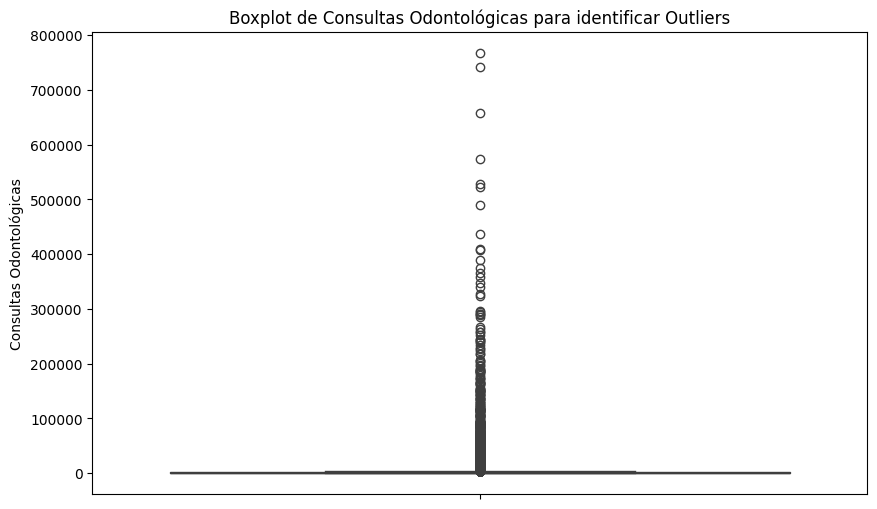

In [128]:
# Crear un boxplot para visualizar la distribución de 'consultas_odontologicas' y los posibles outliers
plt.figure(figsize=(10, 6))
sns.boxplot(y=df_final['consultas_odontologicas'])
plt.title('Boxplot de Consultas Odontológicas para identificar Outliers')
plt.ylabel('Consultas Odontológicas')
plt.show()



Identificación de Outliers por Establecimiento y Año usando IQR:
Total de puntos outliers detectados: 37111


,establecimiento_nombre,anio,columna,valor,limite_inferior_IQR,limite_superior_IQR,indice_original
0,Asociación Hogar de Ancianos de Suipacha,2005,consultas_odontologicas,703,0.000,0.000,1757
1,Asociación Hogar de Ancianos de Suipacha,2005,consultas_medicas,83740,-5397.875,9021.125,1757
2,Asociación Hogar de Ancianos de Suipacha,2005,consultas_paramedicas,1954,-732.250,1345.750,1757
3,Asociación Hogar de Ancianos de Suipacha,2005,egresos,754,0.000,0.000,1757
4,Asociación Hogar de Ancianos de Suipacha,2005,dias_camas_disponible,15437,0.000,0.000,1757



Conteo de Outliers por Establecimiento:
establecimiento_nombre
Centro de Salud N° 41                                    1897
Hospital Materno Infantil Dr. J. Equiza                  1077
Sociedad de Fomento Va. Urquiza Nº 2                      823
Hospital Zonal Especializado en Oncología L. Fortabat     746
Centro de Salud Nº 11                                     725
dtype: int64

Conteo de Outliers por Año:
anio
2017    2916
2016    2905
2015    2889
2010    2885
2014    2869
dtype: int64

Conteo de Outliers por Columna:
columna
consultas_medicas          3515
consultas_paramedicas      2980
consultas_odontologicas    2976
pacientes_dias             2752
porcentaje_ocupacion       2732
dtype: int64


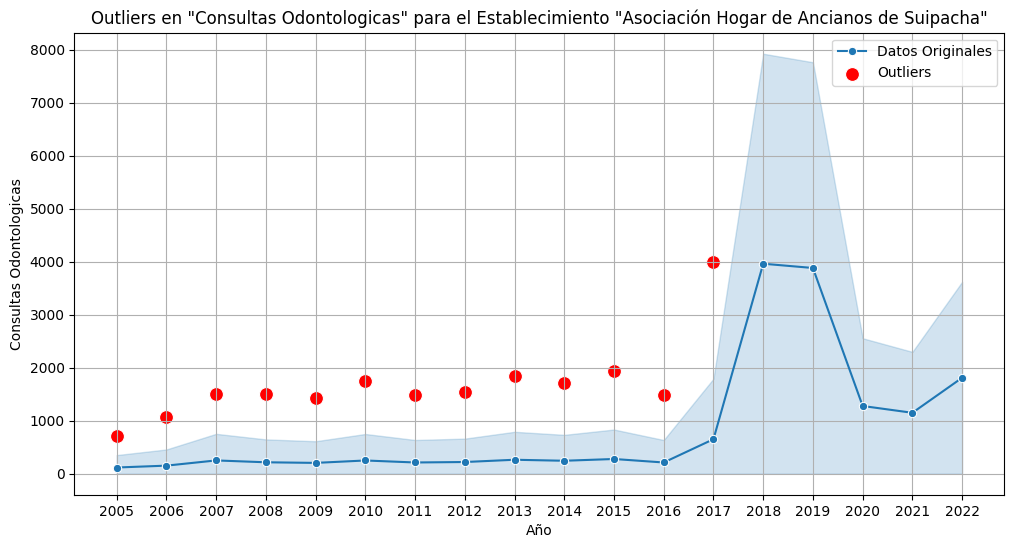

In [129]:
# IDENTIFICAR OUTLIERS por Establecimiento y Año

# Definir las columnas numéricas en las que buscar outliers
cols_to_check_outliers = [
    'consultas_odontologicas',
    'consultas_medicas',
    'consultas_paramedicas',
    'interconsultas',
    'egresos',
    'dias_camas_disponible',
    'promedio_camas_disponibles',
    'pacientes_dias',
    'porcentaje_ocupacion',
    'dias_estadia',
    'promedio_dias_estadia',
    'defunciones',
    'giro_de_camas',
    'tasa_mortalidad_hospitalaria'
]

outliers_list = []

# Iterar sobre cada combinación única de establecimiento_nombre y anio
for (establecimiento, anio), group in df_final.groupby(['establecimiento_nombre', 'anio']):
    # Para cada columna numérica
    for col in cols_to_check_outliers:
        # Asegurarse de que la columna exista y no sea constante (varianza > 0) y tenga suficientes datos
        if col in group.columns and group[col].nunique() > 1 and len(group) > 1:
            Q1 = group[col].quantile(0.25)
            Q3 = group[col].quantile(0.75)
            IQR = Q3 - Q1

            # Definir los límites para los outliers
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            # Identificar las filas que son outliers para esta columna en este grupo
            outlier_rows = group[(group[col] < lower_bound) | (group[col] > upper_bound)]

            # Agregar la información de los outliers a la lista
            if not outlier_rows.empty:
                for index, row in outlier_rows.iterrows():
                    outliers_list.append({
                        'establecimiento_nombre': establecimiento,
                        'anio': anio,
                        'columna': col,
                        'valor': row[col],
                        'limite_inferior_IQR': lower_bound,
                        'limite_superior_IQR': upper_bound,
                        'indice_original': index # Guardar el índice original si es útil
                    })

# Convertir la lista de outliers a un DataFrame
df_outliers = pd.DataFrame(outliers_list)

# Mostrar el DataFrame de outliers
print("\nIdentificación de Outliers por Establecimiento y Año usando IQR:")
if not df_outliers.empty:
    print(f"Total de puntos outliers detectados: {len(df_outliers)}")
    display(df_outliers.head())
    # Puedes agrupar para ver cuántos outliers hay por establecimiento o año
    print("\nConteo de Outliers por Establecimiento:")
    print(df_outliers.groupby('establecimiento_nombre').size().sort_values(ascending=False).head())
    print("\nConteo de Outliers por Año:")
    print(df_outliers.groupby('anio').size().sort_values(ascending=False).head())
    print("\nConteo de Outliers por Columna:")
    print(df_outliers.groupby('columna').size().sort_values(ascending=False).head())

    # Opcional: Visualizar outliers para una columna específica en el tiempo para un establecimiento particular
    # Elige un establecimiento y una columna para visualizar
    establecimiento_ejemplo = df_outliers['establecimiento_nombre'].iloc[0] if not df_outliers.empty else None
    columna_ejemplo = df_outliers['columna'].iloc[0] if not df_outliers.empty else None

    if establecimiento_ejemplo and columna_ejemplo:
        df_plot_outliers = df_outliers[(df_outliers['establecimiento_nombre'] == establecimiento_ejemplo) & (df_outliers['columna'] == columna_ejemplo)]
        df_plot_original = df_final[(df_final['establecimiento_nombre'] == establecimiento_ejemplo)]

        if not df_plot_outliers.empty:
            plt.figure(figsize=(12, 6))
            # Graficar los datos originales de la columna para ese establecimiento
            sns.lineplot(data=df_plot_original, x='anio', y=columna_ejemplo, marker='o', label='Datos Originales')
            # Graficar los puntos identificados como outliers
            sns.scatterplot(data=df_plot_outliers, x='anio', y='valor', color='red', s=100, label='Outliers')

            plt.title(f'Outliers en "{columna_ejemplo.replace("_", " ").title()}" para el Establecimiento "{establecimiento_ejemplo}"')
            plt.xlabel('Año')
            plt.ylabel(columna_ejemplo.replace("_", " ").title())
            plt.xticks(df_plot_original['anio'].unique())
            plt.grid(True)
            plt.legend()
            plt.show()
else:
    print("No se detectaron outliers significativos por establecimiento y año usando el método IQR.")

